In [1]:
import numpy as np
import glob, os
from keras import layers as ly
from keras.models import Sequential, load_model, Model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam, SGD
from keras.layers import Input, Lambda
from keras import losses
from keras.models import model_from_json
import keras.backend.tensorflow_backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
import string
from keras.utils import plot_model

Using TensorFlow backend.


In [2]:
#dir = './sequence/*'
dir = './datasets/seq/*'
alpha = list(string.ascii_uppercase)
chr2index = {alpha[i]:i for i in range(len(alpha))}

In [3]:
def chr2OH(alphabet):
    oh = [0 for i in range(len(alpha))]
    index = chr2index[alphabet]
    oh[index] = 1
    return oh

In [4]:
# file read
all_names = []
all_data = []
sequence_length = []
alpha = list(string.ascii_uppercase)
data_length = len(glob.glob(dir))
file_predix = './datasets/seq/group'
for index in range(1, data_length+1):
    filename = file_predix + str(index) + "/*"
    print(filename)
    files = glob.glob(filename)
    for file in files:
        datasets = []
        all_names.append(file.split('/')[-1].replace('.txt', ''))
        for rf in open(file, 'r'):
            (u, v, w) = rf[1:-2].split(', ')
            datasets.append(chr2OH(u[1]) + chr2OH(v[1]) +[float(w)])
        sequence_length.append(len(datasets))
        all_data.append(datasets)
all_data = np.array([np.array(arr) for arr in all_data])

./datasets/seq/group1/*
./datasets/seq/group2/*
./datasets/seq/group3/*
./datasets/seq/group4/*
./datasets/seq/group5/*
./datasets/seq/group6/*


In [3]:
'''
# file read
all_names = []
all_data = []
sequence_length = []

data_length = len(glob.glob(dir))
file_predix = './datasets/seq/group'
for index in range(1, data_length+1):
    filename = file_predix + str(index) + "/*"
    print(filename)
    files = glob.glob(filename)
    for file in files:
        datasets = []
        all_names.append(file.split('/')[-1].replace('.txt', ''))
        for rf in open(file, 'r'):
            (u, v, w) = rf[1:-2].split(', ')
            datasets.append([alpha.index(u[1])+1, alpha.index(v[1]) +1, float(w)])
        sequence_length.append(len(datasets))
        all_data.append(datasets)
all_data = np.array([np.array(arr) for arr in all_data])
'''

./datasets/seq/group1/*
./datasets/seq/group2/*
./datasets/seq/group3/*
./datasets/seq/group4/*
./datasets/seq/group5/*
./datasets/seq/group6/*


In [5]:
x_train, x_test, train_name, test_name = train_test_split(all_data, all_names, test_size=0.3)
x_test, x_val, test_name, val_name = train_test_split(x_test, test_name, test_size=0.33)

In [6]:
tr_names= []
for name in train_name:
    tr_names.append(name.split('graph')[0])
    #tr_names.append(name.split('-')[0].replace('graph', ''))

In [7]:
max_sequence_length = max(sequence_length)
n_features = 3
batch_size = 32
epochs = 200
steps_per_epoch = len(x_train)

In [8]:
def custom_loss(y_true, y_pred):
    loss1 = losses.mean_squared_error(y_true, y_pred)
    loss2 = losses.kld(y_true, y_pred) # categorical_crossentropy
    return loss1 * 0.7 + loss2 * 0.3

def custom_loss1(y_true, y_pred):
    loss1 = losses.mean_squared_error(y_true, y_pred)
    loss2 = losses.categorical_crossentropy(y_true, y_pred) # categorical_crossentropy
    return loss1 * 0.7 + loss2 * 0.3

In [11]:
def repeat_vector(args):
    layer_to_repeat = args[0]
    sequence_layer = args[1]
    return RepeatVector(K.shape(sequence_layer)[1])(layer_to_repeat)
    

inputs = Input(shape=(None, 53))
encoded = LSTM(128, return_sequences=True)(inputs)  #activation 안적으면 tanh
encoded = LSTM(64)(encoded)

decoded = Lambda(repeat_vector, output_shape=(None, 64)) ([encoded, inputs]) # inputs의 shape[1] 만큼 encoded 를 반복 생성

decoded = LSTM(64, return_sequences=True)(decoded)
decoded = LSTM(128, return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(53))(decoded)
encoder = Model(inputs, encoded)

In [66]:
lstm_autoencoder = Model(inputs, decoded)
lstm_autoencoder.compile(loss=custom_loss, optimizer='adam')#decay=0.9

In [12]:
def val_generator(x_val):
    idx = 0
    while True:
        yield np.array([x_val[idx]]), np.array([x_val[idx]])
        idx += 1
        if idx >= len(x_val):
            idx = 0

def train_generator(x_train):
    idx = 0
    while True:
        yield np.array([x_train[idx]]), np.array([x_train[idx]])
        idx += 1
        if idx >= len(x_train):
            idx = 0

In [69]:
hist = lstm_autoencoder.fit_generator(train_generator(x_train), epochs=200, steps_per_epoch=steps_per_epoch, verbose=1, validation_steps=len(x_val), validation_data=val_generator(x_val))

Epoch 1/200
4297/4297 [==============================] - 57s 13ms/step - loss: 13.4377 - val_loss: 7.8688
Epoch 2/200
4297/4297 [==============================] - 55s 13ms/step - loss: 7.7191 - val_loss: 7.1087
Epoch 3/200
4297/4297 [==============================] - 56s 13ms/step - loss: 6.7656 - val_loss: 6.6259
Epoch 4/200
4297/4297 [==============================] - 55s 13ms/step - loss: 5.9026 - val_loss: 5.7310
Epoch 5/200
4297/4297 [==============================] - 55s 13ms/step - loss: 5.0127 - val_loss: 4.2139
Epoch 6/200
4297/4297 [==============================] - 55s 13ms/step - loss: 4.2918 - val_loss: 3.8127
Epoch 7/200
4297/4297 [==============================] - 55s 13ms/step - loss: 3.6971 - val_loss: 3.1100
Epoch 8/200
4297/4297 [==============================] - 55s 13ms/step - loss: 3.1070 - val_loss: 2.7434
Epoch 9/200
4297/4297 [==============================] - 55s 13ms/step - loss: 2.5996 - val_loss: 2.4723
Epoch 10/200
4297/4297 [==============================

Epoch 155/200
4297/4297 [==============================] - 54s 13ms/step - loss: 0.0948 - val_loss: 0.2931
Epoch 156/200
4297/4297 [==============================] - 54s 13ms/step - loss: 0.0870 - val_loss: 0.1876
Epoch 157/200
4297/4297 [==============================] - 54s 12ms/step - loss: 0.0916 - val_loss: 0.1868
Epoch 158/200
4297/4297 [==============================] - 54s 12ms/step - loss: 0.0941 - val_loss: 0.2031
Epoch 159/200
4297/4297 [==============================] - 54s 12ms/step - loss: 0.1063 - val_loss: 0.2211
Epoch 160/200
4297/4297 [==============================] - 54s 13ms/step - loss: 0.0956 - val_loss: 0.1993
Epoch 161/200
4297/4297 [==============================] - 54s 13ms/step - loss: 0.1051 - val_loss: 0.2491
Epoch 162/200
4297/4297 [==============================] - 54s 13ms/step - loss: 0.1002 - val_loss: 0.2470
Epoch 163/200
4297/4297 [==============================] - 54s 13ms/step - loss: 0.0806 - val_loss: 0.2176
Epoch 164/200
4297/4297 [============

In [73]:
kld_ae = lstm_autoencoder
kld_hist= hist

In [72]:
mse_ae = Model(inputs, decoded)
mse_ae.compile(loss='mse', optimizer='adam')#decay=0.9
mse_hist = mse_ae.fit_generator(train_generator(x_train), epochs=200, steps_per_epoch=steps_per_epoch, verbose=1, validation_steps=len(x_val), validation_data=val_generator(x_val))

Epoch 1/200
4297/4297 [==============================] - 58s 14ms/step - loss: 16.2223 - val_loss: 10.8632
Epoch 2/200
4297/4297 [==============================] - 54s 13ms/step - loss: 10.6599 - val_loss: 10.3769
Epoch 3/200
4297/4297 [==============================] - 54s 13ms/step - loss: 9.9820 - val_loss: 9.1238
Epoch 4/200
4297/4297 [==============================] - 54s 13ms/step - loss: 8.6401 - val_loss: 7.7204
Epoch 5/200
4297/4297 [==============================] - 54s 13ms/step - loss: 7.0021 - val_loss: 6.2123
Epoch 6/200
4297/4297 [==============================] - 54s 13ms/step - loss: 5.6057 - val_loss: 5.0205
Epoch 7/200
4297/4297 [==============================] - 54s 13ms/step - loss: 4.6690 - val_loss: 4.3374
Epoch 8/200
4297/4297 [==============================] - 54s 13ms/step - loss: 4.0689 - val_loss: 3.7772
Epoch 9/200
4297/4297 [==============================] - 54s 13ms/step - loss: 3.6151 - val_loss: 3.8171
Epoch 10/200
4297/4297 [===========================

Epoch 155/200
4297/4297 [==============================] - 51s 12ms/step - loss: 0.1358 - val_loss: 0.2268
Epoch 156/200
4297/4297 [==============================] - 51s 12ms/step - loss: 0.1310 - val_loss: 0.2931
Epoch 157/200
4297/4297 [==============================] - 51s 12ms/step - loss: 0.1363 - val_loss: 0.2528
Epoch 158/200
4297/4297 [==============================] - 51s 12ms/step - loss: 0.1089 - val_loss: 0.1912
Epoch 159/200
4297/4297 [==============================] - 51s 12ms/step - loss: 0.1385 - val_loss: 0.2136
Epoch 160/200
4297/4297 [==============================] - 51s 12ms/step - loss: 0.1139 - val_loss: 0.2152
Epoch 161/200
4297/4297 [==============================] - 51s 12ms/step - loss: 0.1311 - val_loss: 0.2402
Epoch 162/200
4297/4297 [==============================] - 51s 12ms/step - loss: 0.1121 - val_loss: 0.2067
Epoch 163/200
4297/4297 [==============================] - 51s 12ms/step - loss: 0.1406 - val_loss: 0.1896
Epoch 164/200
4297/4297 [============

In [13]:
cce_ae = Model(inputs, decoded)
cce_ae.compile(loss=custom_loss1, optimizer=SGD(lr=0.005, decay=1e-6, momentum=0.9, nesterov=True))#Adam(lr=0.003))#decay=0.9
cce_hist = cce_ae.fit_generator(train_generator(x_train), epochs=200, steps_per_epoch=steps_per_epoch, verbose=1, validation_steps=len(x_val), validation_data=val_generator(x_val))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/200
4297/4297 [==============================] - 47s 11ms/step - loss: 54.6271 - val_loss: 36.6902
Epoch 2/200
4297/4297 [==============================] - 45s 11ms/step - loss: 26.9952 - val_loss: 12.4484
Epoch 3/200
4297/4297 [==============================] - 46s 11ms/step - loss: 26.7161 - val_loss: 38.2664
Epoch 4/200
4297/4297 [==============================] - 46s 11ms/step - loss: 22.9892 - val_loss: 37.7301
Epoch 5/200
4297/4297 [==============================] - 46s 11ms/step - loss: 22.4545 - val_loss: 38.0681
Epoch 6/200
4297/4297 [==============================] - 46s 11ms/step - loss: 22.1784 - val_loss: 14.9484
Epoch 7/200
4297/4297 [==============================] - 46s 11ms/step - loss: 22.2445 - val_loss: 12.3930
Epoch 8/200
4297/4297 [==============================] - 46s 11ms/step - loss: 22.1214 - val_loss: 37.8404
Epoch 9/200
4297/4297 [==========================

4297/4297 [==============================] - 45s 10ms/step - loss: 31.8925 - val_loss: 32.1540
Epoch 72/200
4297/4297 [==============================] - 45s 11ms/step - loss: 31.8909 - val_loss: 32.1520
Epoch 73/200
4297/4297 [==============================] - 45s 11ms/step - loss: 31.8894 - val_loss: 32.1499
Epoch 74/200
4297/4297 [==============================] - 45s 10ms/step - loss: 31.8879 - val_loss: 32.1479
Epoch 75/200
4297/4297 [==============================] - 45s 11ms/step - loss: 31.8864 - val_loss: 32.1457
Epoch 76/200
4297/4297 [==============================] - 45s 11ms/step - loss: 31.8849 - val_loss: 32.1439
Epoch 77/200
4297/4297 [==============================] - 46s 11ms/step - loss: 31.8834 - val_loss: 32.1420
Epoch 78/200
4297/4297 [==============================] - 46s 11ms/step - loss: 31.8825 - val_loss: 32.1393
Epoch 79/200
4297/4297 [==============================] - 46s 11ms/step - loss: 31.8805 - val_loss: 32.1382
Epoch 80/200
4297/4297 [=================

4297/4297 [==============================] - 45s 10ms/step - loss: 31.8140 - val_loss: 32.0515
Epoch 147/200
4297/4297 [==============================] - 45s 10ms/step - loss: 31.8132 - val_loss: 32.0507
Epoch 148/200
4297/4297 [==============================] - 45s 11ms/step - loss: 31.8125 - val_loss: 32.0498
Epoch 149/200
4297/4297 [==============================] - 45s 11ms/step - loss: 31.8118 - val_loss: 32.0489
Epoch 150/200
4297/4297 [==============================] - 45s 11ms/step - loss: 31.8112 - val_loss: 32.0481
Epoch 151/200
4297/4297 [==============================] - 45s 10ms/step - loss: 31.8105 - val_loss: 32.0472
Epoch 152/200
4297/4297 [==============================] - 45s 10ms/step - loss: 31.8098 - val_loss: 32.0465
Epoch 153/200
4297/4297 [==============================] - 45s 11ms/step - loss: 31.8092 - val_loss: 32.0457
Epoch 154/200
4297/4297 [==============================] - 45s 11ms/step - loss: 31.8084 - val_loss: 32.0448
Epoch 155/200
4297/4297 [========

In [16]:
import json

In [17]:
#kld_json = kld_ae.to_json()
#mse_json = mse_ae.to_json()
cce_json = cce_ae.to_json()
models = [cce_ae] #[kld_ae, mse_ae, cce_ae]
models_json = [cce_json] #[kld_json, mse_json, cce_json]
filenames = ['cce_oh_model1'] #['kld_oh_model', 'mse_oh_model', 'cce_oh_model']
histories = [cce_hist] #[kld_hist, mse_hist, cce_hist]

for filename, model, model_json, hist in zip(filenames, models, models_json,histories):
    with open('models/' + filename + '.json', 'w') as file:
        file.write(model_json)
    model.save_weights('models/weights_' + filename + '.h5')
    with open('models/' + filename + '_history.json', 'w') as file:
        json.dump(hist.history, file)

In [36]:
# MODEL SAVE
model_json = lstm_autoencoder1.to_json()
filename = 'mse_model' #input('filename: ') 
with open('models/' + filename + '.json', 'w') as file:
    file.write(model_json)
lstm_autoencoder1.save_weights('models/weights_' +  filename + '.h5')

In [37]:
import json
with open('models/mse_history.json', 'w') as f:
    json.dump(hist1.history, f)

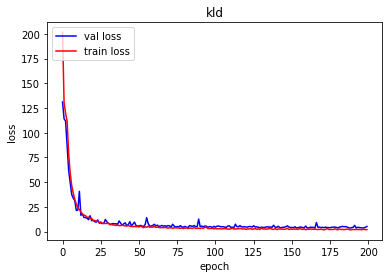

In [49]:
import matplotlib.pyplot as plt
h1 = json.load(open('models/kld_history.json', 'r'))

fig, loss_ax = plt.subplots()

loss_ax.plot(h1['val_loss'], 'b', label='val loss')
loss_ax.plot(h1['loss'], 'r', label='train loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

plt.title('kld')
plt.show()

In [17]:
loaded_model = lstm_autoencoder

In [18]:
mean= 0
for xt in x_test:
    xt = xt.reshape(1, xt.shape[0], xt.shape[1])
    out = loaded_model.predict(xt)
    mean += ((xt-out)**2).mean(axis=None)
print(mean/len(x_test))

7.311564968588939


In [4]:
filename = "last_mse_kld_lstmae"
# MODEL LOAD
loaded_model = model_from_json(open('res/kld/' +filename + '.json').read())
loaded_model.load_weights('res/kld/weights_' + filename + '.h5')

W1022 19:19:46.648915 140479360071424 deprecation_wrapper.py:119] From /home/minji/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1022 19:19:46.658055 140479360071424 deprecation_wrapper.py:119] From /home/minji/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1022 19:19:46.687883 140479360071424 deprecation_wrapper.py:119] From /home/minji/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1022 19:19:47.154119 140479360071424 deprecation_wrapper.py:119] From /home/minji/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



In [16]:
encoder = Model(loaded_model.input, loaded_model.layers[3].output)

In [ ]:
test = x_test[0].reshape(1, x_test[0].shape[0], x_test[0].shape[1])
latent_vector = []
for x in x_test:
    x = x.reshape(1, x.shape[0], x.shape[1])
    latent_vector.append(encoder.predict(x)[0])

In [23]:
model_path = 'model_save/mse_kld_models/weights' + '{epoch:02d}-{loss:.4f}.h5'
early_stopping_callback = EarlyStopping(monitor='loss', patience=200)
checkpoint_callback = ModelCheckpoint(model_path, monitor='loss', verbose = 1, save_best_only = True, save_weights_only = True, mode='min', period=100)

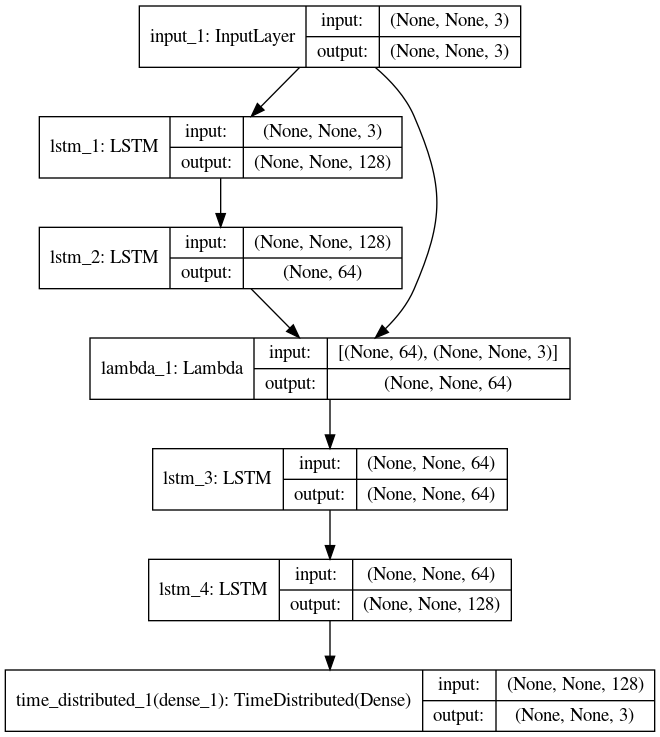

In [5]:
plot_model(loaded_model, to_file='./model.png', show_shapes=True, show_layer_names=True)